# Making a Deep Convolution WGAN with Gradient Penalty and with attention on hand images

## Boring imports and datasets (Same for most of the Notebooks that use MNIST)

In [1]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sklearn.model_selection as ms
from tqdm import tqdm,trange
import albumentations as A
from torchvision import transforms
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import os 

In [2]:
class Hyperparams:
    num_epochs = 20
    discriminator_lr = 5e-4
    generator_lr = 5e-4
    num_latent_features = 100
    
    discriminator_steps = 5
    grad_penalty_lambda = 10 
    
    normalise_transform = transforms.Compose([
        transforms.Normalize(mean=(0.5), std=(0.5))
        ])

In [3]:
class MNIST_Dataset(Dataset):
    def __init__(self, metadata_df, images, normalise_transform = Hyperparams.normalise_transform ):
        self.metadata_df = metadata_df
        self.images = images
        self.normalise_transform = normalise_transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self,idx):
        idx = int(idx)

        image = torch.tensor(images[idx]).unsqueeze(0)
        label = torch.tensor([1])

        if self.normalise_transform:
            image = self.normalise_transform(image.float())

        return image, label

In [4]:
metadata = pd.read_csv('data/HANDMNIST/metadata.csv')
train_metadata, valid_metadata = ms.train_test_split(metadata, test_size=0.2, train_size=0.8, random_state=19, shuffle=True, stratify=metadata['label'])

images = np.load('data/HANDMNIST/images.npy') / 255

In [5]:
train_dataset = MNIST_Dataset(train_metadata.reset_index(), images[train_metadata.index])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)

valid_dataset = MNIST_Dataset(valid_metadata.reset_index(), images[valid_metadata.index])
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=256)

## Fun part: models

In [6]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, num_channels, num_attention_heads, img_size):
        super(SelfAttentionLayer, self).__init__()

        self.num_channels = num_channels
        self.img_size = img_size
        self.num_attention_heads = num_attention_heads
        self.head_dim = num_channels // num_attention_heads

        self.make_querys = nn.Linear(img_size**2, img_size**2)
        self.make_keys = nn.Linear(img_size**2, img_size**2)
        self.make_values = nn.Linear(img_size**2, img_size**2)


        self.out = nn.Linear(img_size**2, img_size**2)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, self.num_channels, self.img_size * self.img_size)

        querys = self.make_querys(x).view(batch_size, self.num_attention_heads, self.head_dim, -1)
        keys = self.make_keys(x).view(batch_size, self.num_attention_heads, self.head_dim, -1)
        values = self.make_values(x).view(batch_size, self.num_attention_heads, self.head_dim, -1)

        scale_factor = self.head_dim ** 0.5
        attention_weights = torch.softmax(querys @ keys.transpose(-2, -1) / scale_factor, axis=-1)
        attention_values = attention_weights @ values

        attentioned_values = attention_values.view(batch_size, self.num_channels, self.img_size * self.img_size)
        out = self.out(attentioned_values).view(batch_size, self.num_channels, self.img_size, self.img_size)
        x = x.view(batch_size, self.num_channels, self.img_size, self.img_size)

        return x + out

In [7]:
class PrintShape(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

class Generator(nn.Module):
    def __init__(self,num_latent_features):
        super(Generator, self).__init__()

        self.first_linear = nn.Sequential(
            nn.Linear(num_latent_features,1024),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.InstanceNorm2d(512, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(), #torch.Size([25, 128, 8, 8])
            SelfAttentionLayer(num_channels = 128, num_attention_heads = 8,img_size = 8),
            nn.ReLU(), #torch.Size([25, 128, 8, 8]
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
        
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.ReLU(),
        
            nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.first_linear(x).view(-1,1024,1,1)
        x = self.decoder(x);
        return x


class Discriminator(nn.Module):
    def __init__(self,num_embeddings):
        super(Discriminator, self).__init__()
        self.num_embeddings = num_embeddings

        self.encoder = nn.Sequential(
            # 32x32 to 28x28
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=0),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.1),
            
            # 28x28 to 14x14
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.1),
        
            # 14x14 to 7x7
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.1),
        
            # 7x7 to 3x3
            nn.Conv2d(256, 512, kernel_size=2, stride=2),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.1),
        
            # 3x3 to 1x1
            nn.Conv2d(512, self.num_embeddings, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.1),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.num_embeddings, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
        )

    def forward(self, x):
        x = self.encoder(x).view(-1,self.num_embeddings)
        x = self.classifier(x)
        return x



#Init all wieghts but a value sampled from a (0,0.02) Normal distrib (Very important for Vanilla GAN convergence)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1 or classname.find('Instance') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Train / Valid (and Gradient Penalty implementation)

In [8]:
def gradient_penalty(discriminator, real_images, fake_images, device):
    alpha = torch.rand((real_images.shape[0],1,1,1)).to(device)

    interpolated_images = alpha* real_images + (1-alpha) * fake_images
    interpolated_images.requires_grad = True

    interpolated_images_credibility = discriminator(interpolated_images)

    ones = torch.ones_like(interpolated_images_credibility)
    grad_params = torch.autograd.grad(outputs = interpolated_images_credibility, inputs = interpolated_images, create_graph= True, grad_outputs= ones)[0]

    grad_norm = grad_params.view(grad_params.size(0), -1).norm(2, dim = 1)
    grad_penalty = torch.mean((grad_norm -1 ) ** 2)
    
    return grad_penalty

In [9]:
def train(train_loader, generator, discriminator, device, g_optimizer, d_optimizer, distribution,epoch):
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    d_losses = []
    g_losses = []
        
    for index, batch in enumerate(tqdm(train_loader, total = len(train_loader))):

        #First Step -> Discriminator training
        discriminator.train()
        generator.eval()
        
        images, _ = batch
        real_images = images.to(device)

        for _ in range(Hyperparams.discriminator_steps):
            latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
            with torch.no_grad():
                fake_images = generator(latent_samples)

            discriminator_real_score = discriminator(real_images)
            discriminator_fake_score = discriminator(fake_images)

            grad_penalty = gradient_penalty(discriminator, real_images, fake_images, device)

            discriminator_loss = (torch.mean(discriminator_real_score) - torch.mean(discriminator_fake_score)) #Discriminator job is for this value to be the biggest possible
            discriminator_loss = -discriminator_loss + Hyperparams.grad_penalty_lambda * grad_penalty # Goal of getting max -> now is min and add gradient penalty

            d_losses.append(discriminator_loss.item())
            d_optimizer.zero_grad()
            discriminator_loss.backward()
            d_optimizer.step()


        #Second Step -> Generator training
        discriminator.eval()
        generator.train()
        
        latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
        fake_images = generator(latent_samples)

        credibility = torch.mean(discriminator(fake_images))
        generator_loss = -credibility #Goal for the generator is to have the highest credibility for his images (so the lower negative credibility)
        
        g_losses.append(generator_loss.item())
        g_optimizer.zero_grad()
        generator_loss.backward()
        g_optimizer.step()
    
    mean_d_loss = np.mean(d_losses)
    mean_g_loss = np.mean(g_losses)
    print(f'Training Discriminator loss : {mean_d_loss} | Training Generator loss : {mean_g_loss}')

In [10]:
def validate(valid_loader, generator, discriminator, device, distribution, fixed_latent_vectors,epoch):
    discriminator.eval()
    generator.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    with torch.no_grad():
        for index, batch in enumerate(tqdm(valid_loader, total = len(valid_loader))):
    
            #First Step -> Validate Discriminator
            images, _ = batch
            real_images = images.to(device)
            latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
            fake_images = generator(latent_samples)
            images = torch.cat([real_images,fake_images])
            
            ones, zeros = torch.ones(real_images.shape[0]), torch.zeros(fake_images.shape[0])
            labels = torch.cat([ones,zeros],0).unsqueeze(1).to(device)
            
            random_indices =  torch.randperm(images.shape[0])
            images = images[random_indices]
            labels = labels[random_indices]
    
            discriminator_outputs = discriminator(images)
            discriminator_preds = torch.sigmoid(discriminator_outputs)
            
            all_preds = torch.cat([all_preds,discriminator_preds], 0)
            all_labels = torch.cat([all_labels,labels], 0)
    
        
        accuracy = (((all_preds > 0.5) == all_labels).sum() / all_labels.shape[0]).item()
        print(f'Valid Discriminator accuracy : {accuracy}')
    
        #Second Step -> Validate Generator
        fixed_latent_vectors = fixed_latent_vectors.to(device)
        fake_images = generator(fixed_latent_vectors)
        credibility = discriminator(fake_images)

        fake_images_np = fake_images.cpu().detach().numpy()
        credibility_np = credibility.cpu().detach().numpy()
        
        fig, axes = plt.subplots(5, 5, figsize=(8, 8))  # Change the subplot dimensions to 5x5
        
        # Assume fake_images_np is (25, latent_space) and credibility_np is (25,)
        for i in range(5):
            for j in range(5):
                ax = axes[i, j]
                img = fake_images_np[5 * i + j]
                score = credibility_np[5 * i + j]
                ax.imshow(img[0], cmap='gray')
                ax.set_title(f"Credibility: {score.item():.1f}")
                ax.axis('off')
        
        plt.tight_layout()
        save_dir = "saved_plots"
        
        os.makedirs(save_dir, exist_ok = True)
        os.makedirs(save_dir + '/HANDS_Attention-WDCGAN-GP', exist_ok = True)
    
        plot_filename = os.path.join(save_dir, f"HANDS_Attention-WDCGAN-GP/plot_epoch_{epoch}.png")
        plt.tight_layout()
        plt.savefig(plot_filename)
    
        plt.show()
    
        return accuracy, fig

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(num_latent_features = Hyperparams.num_latent_features).to(device)
generator.apply(weights_init)
discriminator = Discriminator(num_embeddings = 1024).to(device)
discriminator.apply(weights_init)

distribution = torch.distributions.Normal(0, 1)
fixed_latent_vectors = distribution.sample((25, Hyperparams.num_latent_features))


d_optimizer = optim.Adam(discriminator.parameters(), lr=Hyperparams.discriminator_lr, betas=(0, 0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=Hyperparams.generator_lr, betas=(0, 0.9))

Epoch 1/20


100%|██████████| 217/217 [00:52<00:00,  4.10it/s]


Training Discriminator loss : -0.6287697590715874 | Training Generator loss : -0.4641622041742648


100%|██████████| 28/28 [00:00<00:00, 33.90it/s]


Valid Discriminator accuracy : 0.4999999701976776


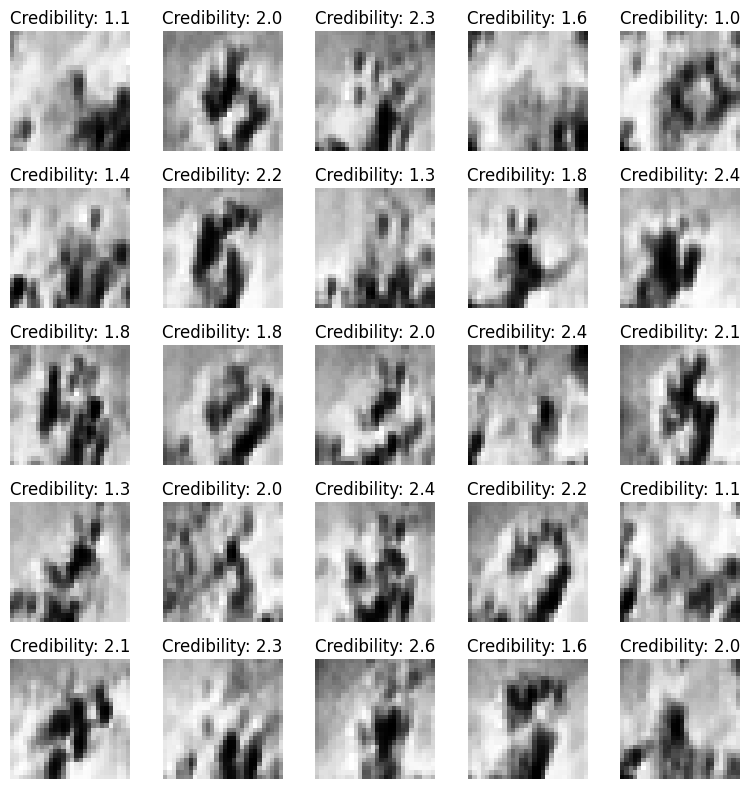

----------------------------------------------------------------------------------------------------
Epoch 2/20


100%|██████████| 217/217 [00:50<00:00,  4.31it/s]


Training Discriminator loss : -1.936837245681868 | Training Generator loss : -0.9579179422835463


100%|██████████| 28/28 [00:00<00:00, 35.69it/s]


Valid Discriminator accuracy : 0.5057753324508667


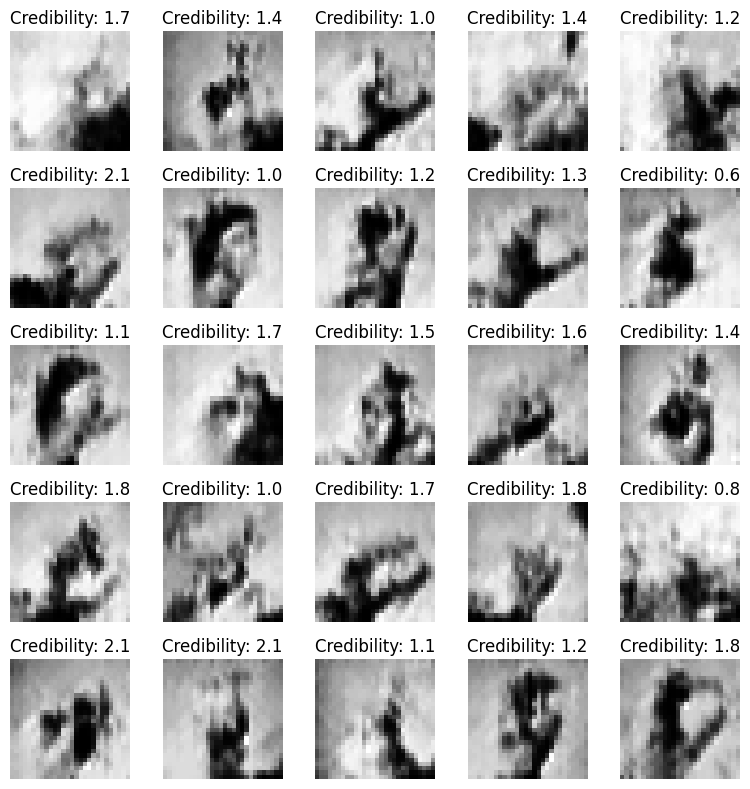

----------------------------------------------------------------------------------------------------
Epoch 3/20


100%|██████████| 217/217 [00:51<00:00,  4.22it/s]


Training Discriminator loss : -2.1054660946542767 | Training Generator loss : -1.216607141836379


100%|██████████| 28/28 [00:00<00:00, 35.49it/s]


Valid Discriminator accuracy : 0.5570314526557922


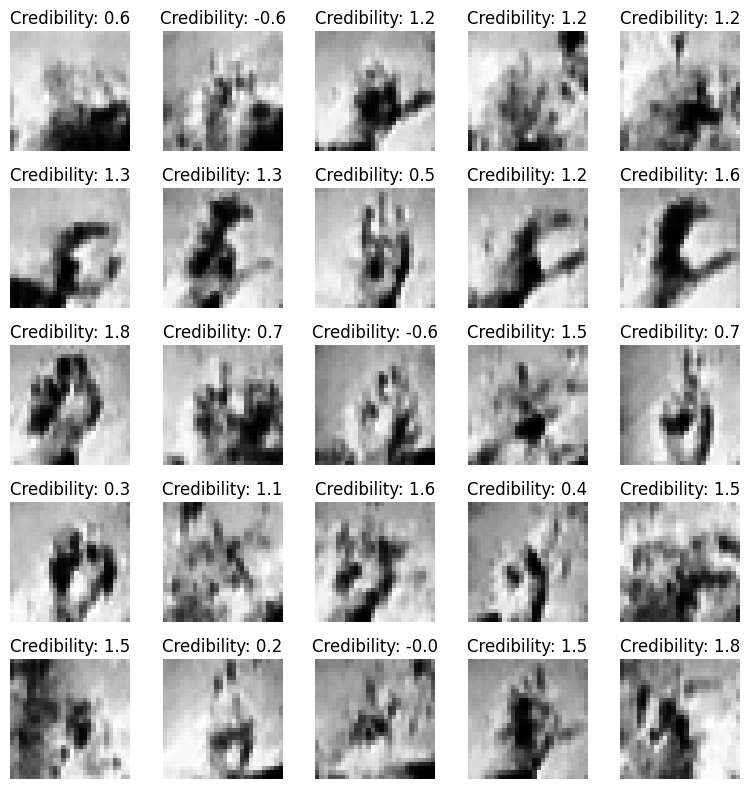

----------------------------------------------------------------------------------------------------
Epoch 4/20


100%|██████████| 217/217 [00:50<00:00,  4.26it/s]


Training Discriminator loss : -2.22347549903228 | Training Generator loss : -1.243545337743233


100%|██████████| 28/28 [00:00<00:00, 35.74it/s]


Valid Discriminator accuracy : 0.500072181224823


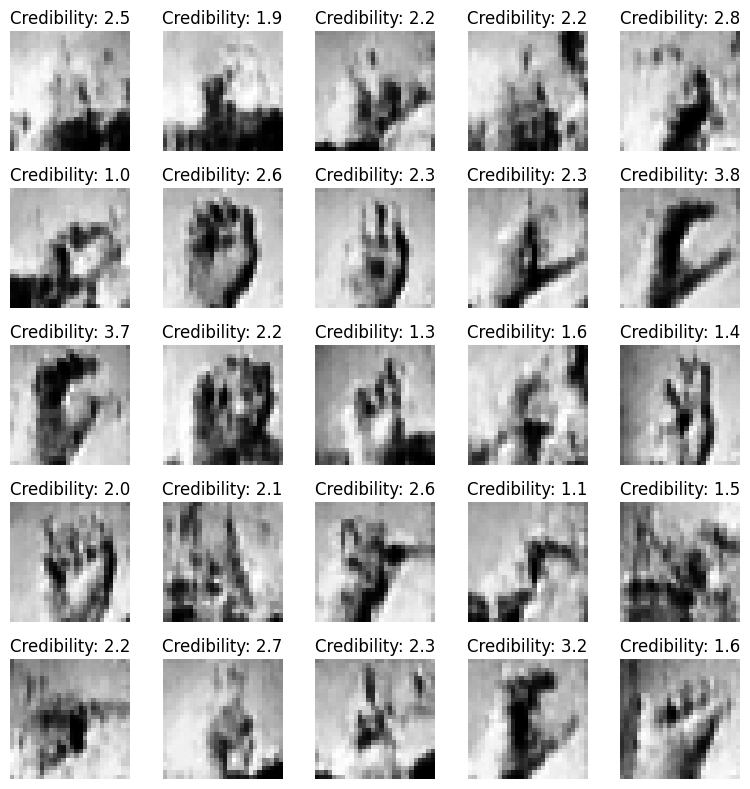

----------------------------------------------------------------------------------------------------
Epoch 5/20


100%|██████████| 217/217 [00:50<00:00,  4.27it/s]


Training Discriminator loss : -2.2994976139837697 | Training Generator loss : -1.3262812566647333


100%|██████████| 28/28 [00:00<00:00, 35.33it/s]


Valid Discriminator accuracy : 0.4999999701976776


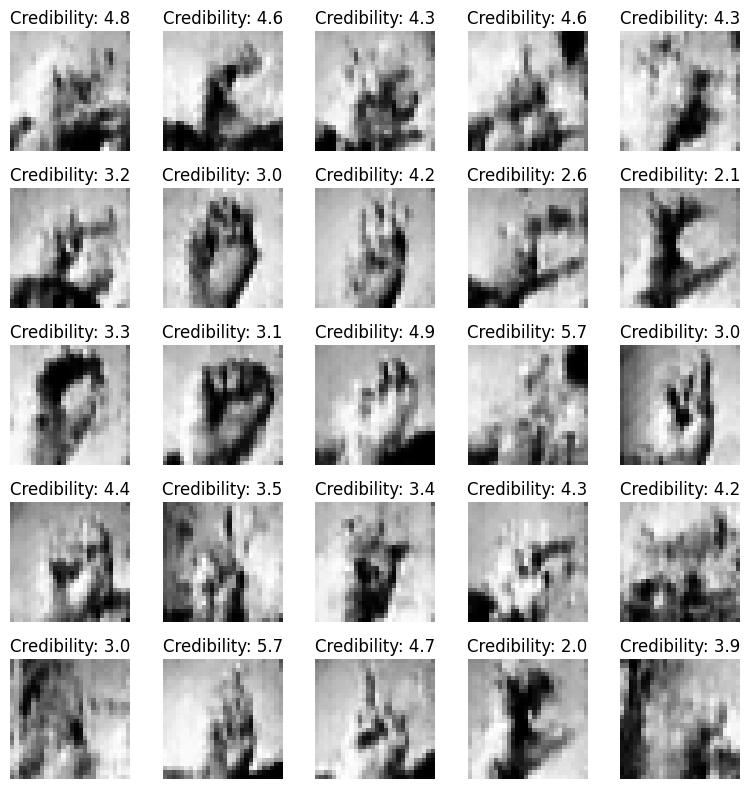

----------------------------------------------------------------------------------------------------
Epoch 6/20


100%|██████████| 217/217 [00:51<00:00,  4.24it/s]


Training Discriminator loss : -2.3487754148821676 | Training Generator loss : -1.2587428052441865


100%|██████████| 28/28 [00:00<00:00, 35.06it/s]


Valid Discriminator accuracy : 0.5251227021217346


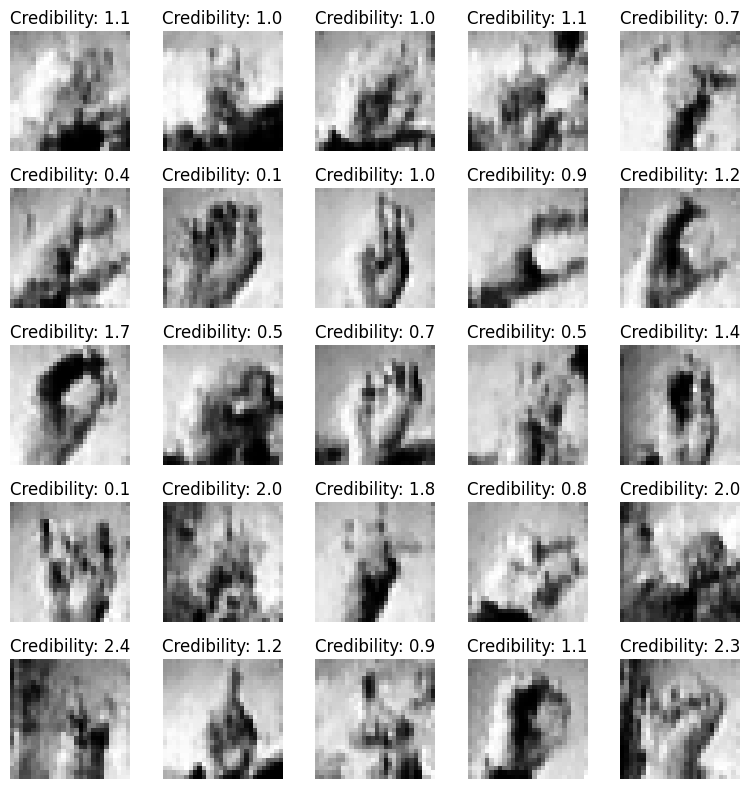

----------------------------------------------------------------------------------------------------
Epoch 7/20


100%|██████████| 217/217 [00:51<00:00,  4.20it/s]


Training Discriminator loss : -2.3906685326505914 | Training Generator loss : -1.3009696605568108


100%|██████████| 28/28 [00:00<00:00, 35.49it/s]


Valid Discriminator accuracy : 0.5027432441711426


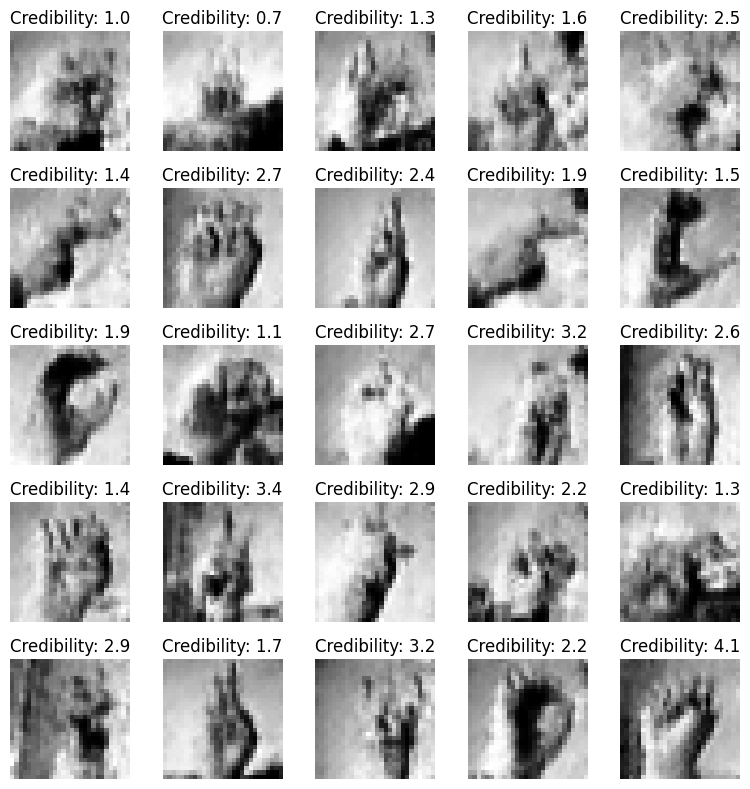

----------------------------------------------------------------------------------------------------
Epoch 8/20


100%|██████████| 217/217 [00:51<00:00,  4.18it/s]


Training Discriminator loss : -2.4233965580913877 | Training Generator loss : -1.408218679773677


100%|██████████| 28/28 [00:00<00:00, 35.76it/s]


Valid Discriminator accuracy : 0.5035373568534851


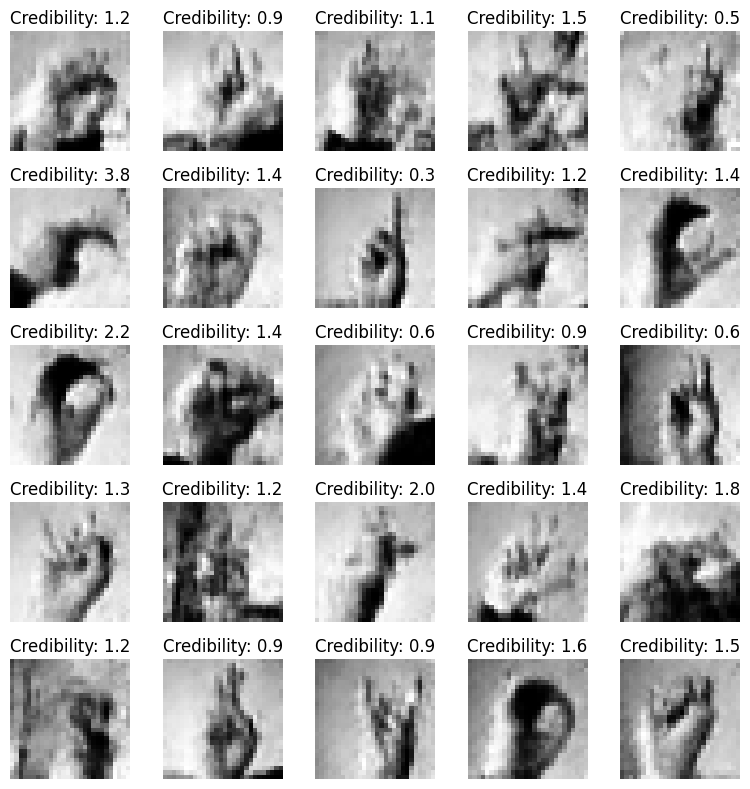

----------------------------------------------------------------------------------------------------
Epoch 9/20


100%|██████████| 217/217 [00:51<00:00,  4.19it/s]


Training Discriminator loss : -2.4632585912256197 | Training Generator loss : -1.65840572877551


100%|██████████| 28/28 [00:00<00:00, 35.45it/s]


Valid Discriminator accuracy : 0.4999999701976776


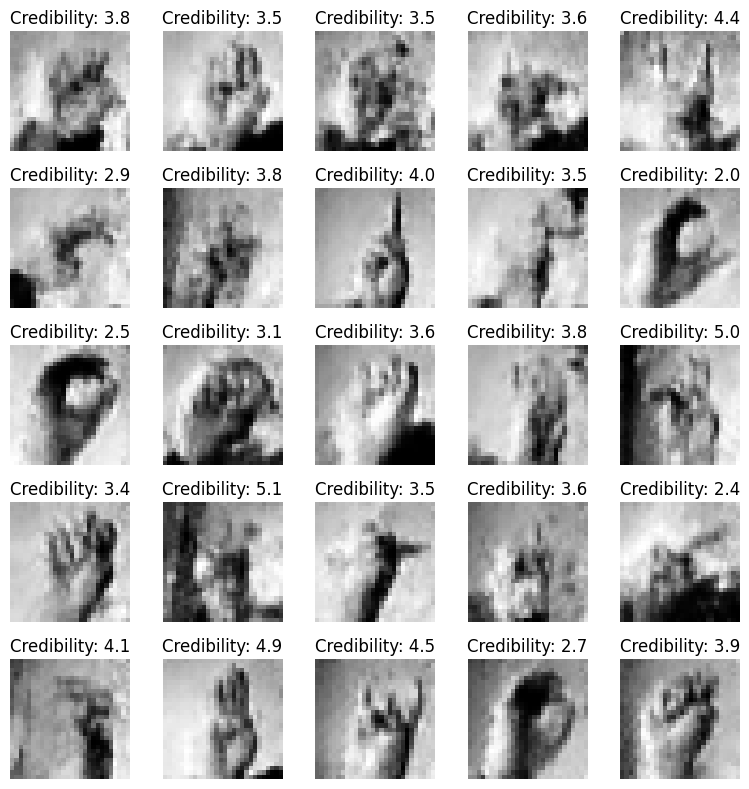

----------------------------------------------------------------------------------------------------
Epoch 10/20


100%|██████████| 217/217 [00:51<00:00,  4.17it/s]


Training Discriminator loss : -2.5006755419041156 | Training Generator loss : -1.86769143429323


100%|██████████| 28/28 [00:00<00:00, 36.14it/s]


Valid Discriminator accuracy : 0.4999999701976776


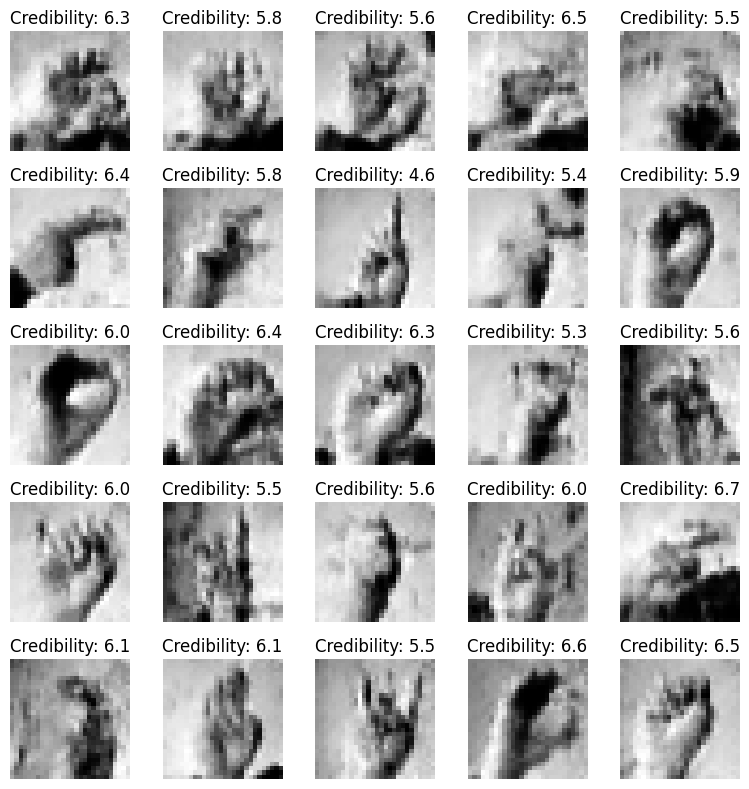

----------------------------------------------------------------------------------------------------
Epoch 11/20


100%|██████████| 217/217 [00:51<00:00,  4.21it/s]


Training Discriminator loss : -2.514443466026113 | Training Generator loss : -2.013951088357631


100%|██████████| 28/28 [00:00<00:00, 35.57it/s]


Valid Discriminator accuracy : 0.4999999701976776


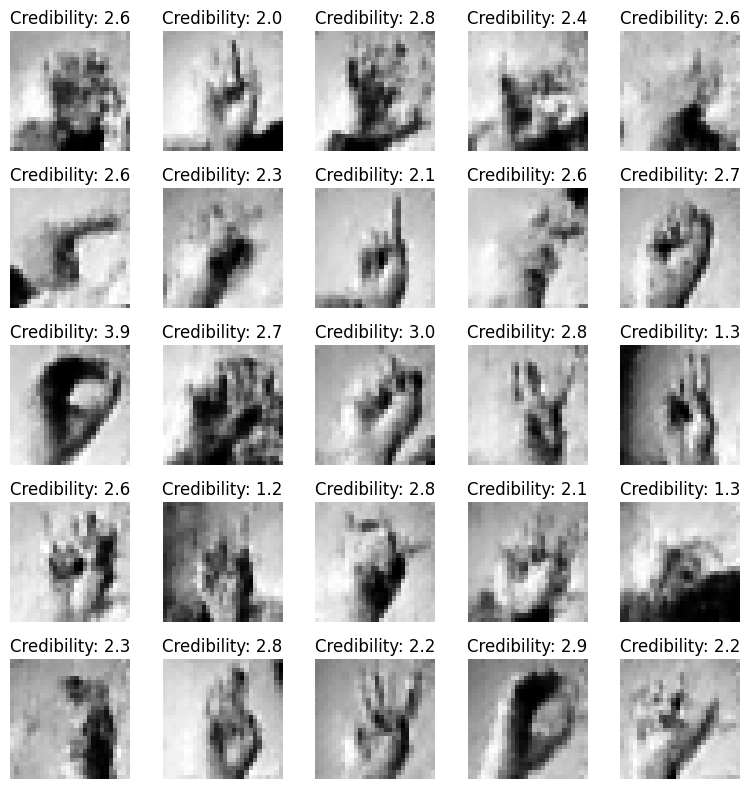

----------------------------------------------------------------------------------------------------
Epoch 12/20


100%|██████████| 217/217 [00:51<00:00,  4.20it/s]


Training Discriminator loss : -2.533587207222864 | Training Generator loss : -2.2806418816202796


100%|██████████| 28/28 [00:00<00:00, 35.48it/s]


Valid Discriminator accuracy : 0.4999999701976776


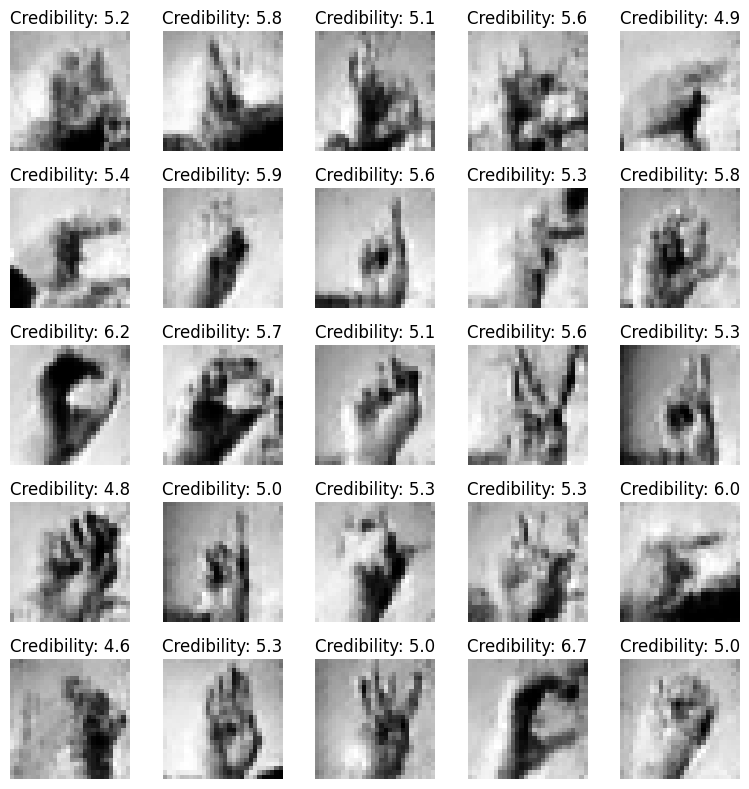

----------------------------------------------------------------------------------------------------
Epoch 13/20


100%|██████████| 217/217 [00:50<00:00,  4.32it/s]


Training Discriminator loss : -2.5224949241783214 | Training Generator loss : -2.4223383809976315


100%|██████████| 28/28 [00:00<00:00, 44.34it/s]


Valid Discriminator accuracy : 0.4999999701976776


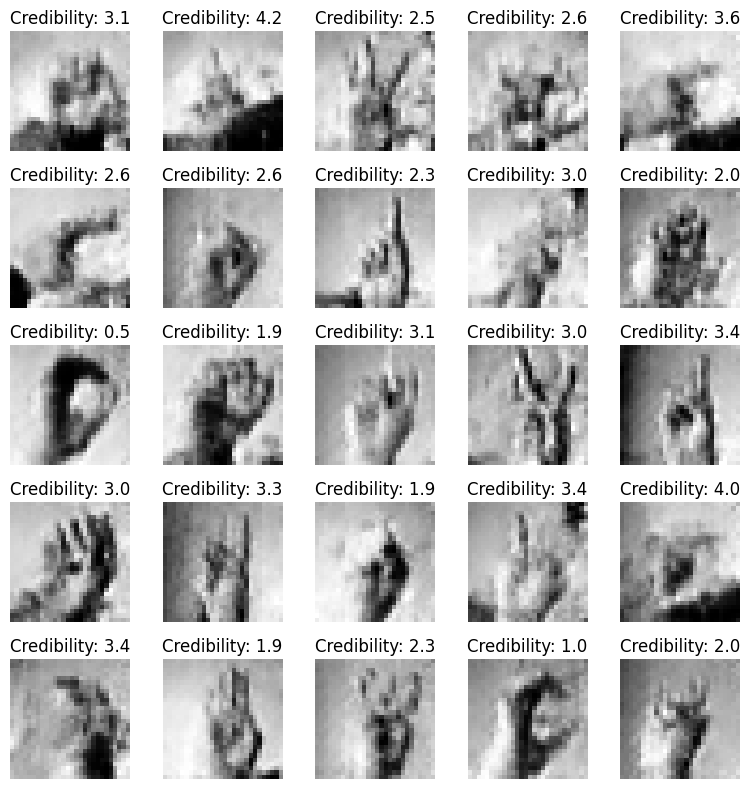

----------------------------------------------------------------------------------------------------
Epoch 14/20


100%|██████████| 217/217 [00:51<00:00,  4.18it/s]


Training Discriminator loss : -2.5508318501683425 | Training Generator loss : -2.3538778825289643


100%|██████████| 28/28 [00:00<00:00, 35.58it/s]


Valid Discriminator accuracy : 0.5009384751319885


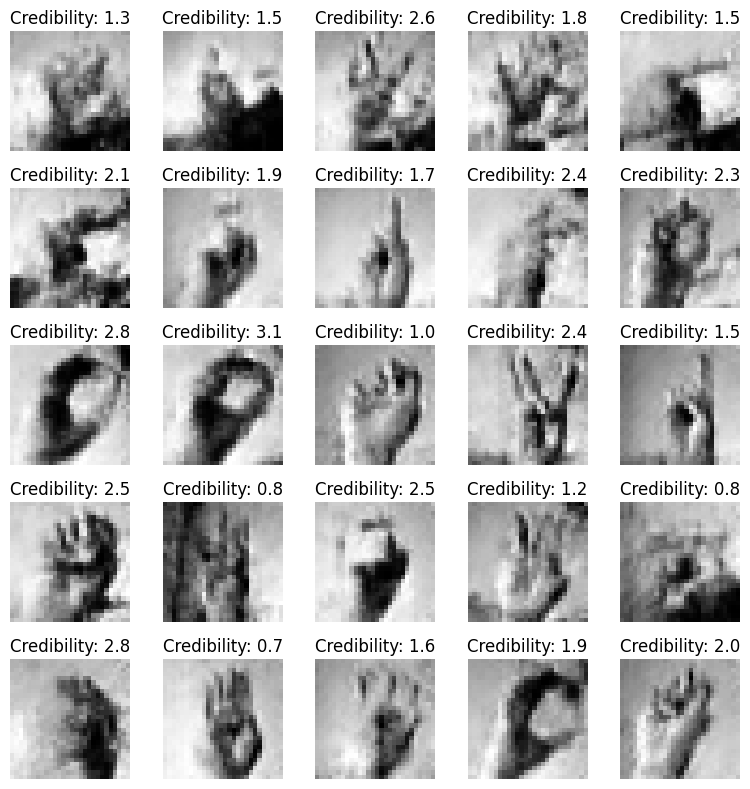

----------------------------------------------------------------------------------------------------
Epoch 15/20


100%|██████████| 217/217 [00:50<00:00,  4.32it/s]


Training Discriminator loss : -2.544348997948906 | Training Generator loss : -2.321550218603029


100%|██████████| 28/28 [00:00<00:00, 44.42it/s]


Valid Discriminator accuracy : 0.4999999701976776


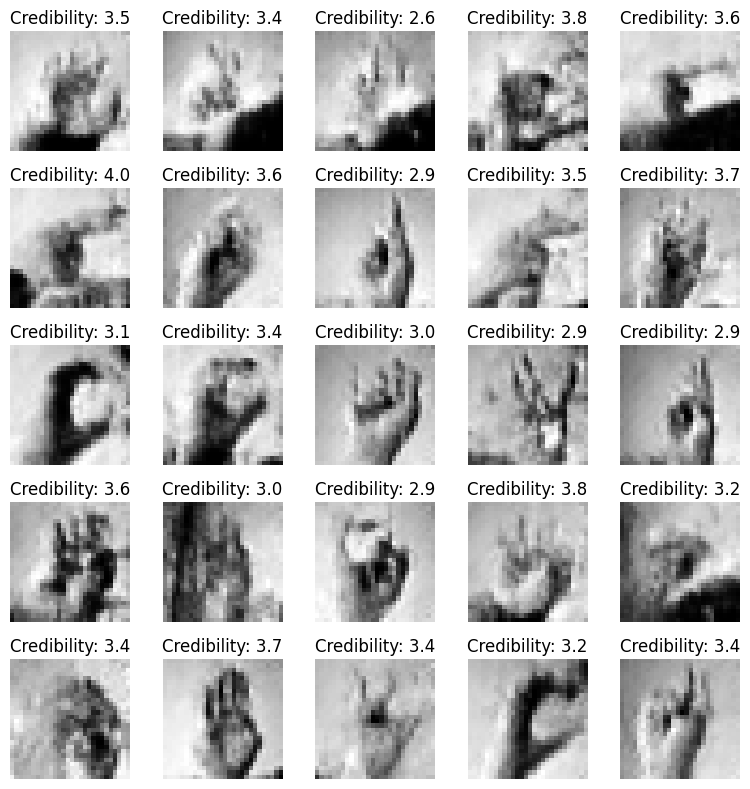

----------------------------------------------------------------------------------------------------
Epoch 16/20


100%|██████████| 217/217 [00:50<00:00,  4.32it/s]


Training Discriminator loss : -2.548297816707242 | Training Generator loss : -2.5129690007542687


100%|██████████| 28/28 [00:00<00:00, 44.29it/s]


Valid Discriminator accuracy : 0.4999999701976776


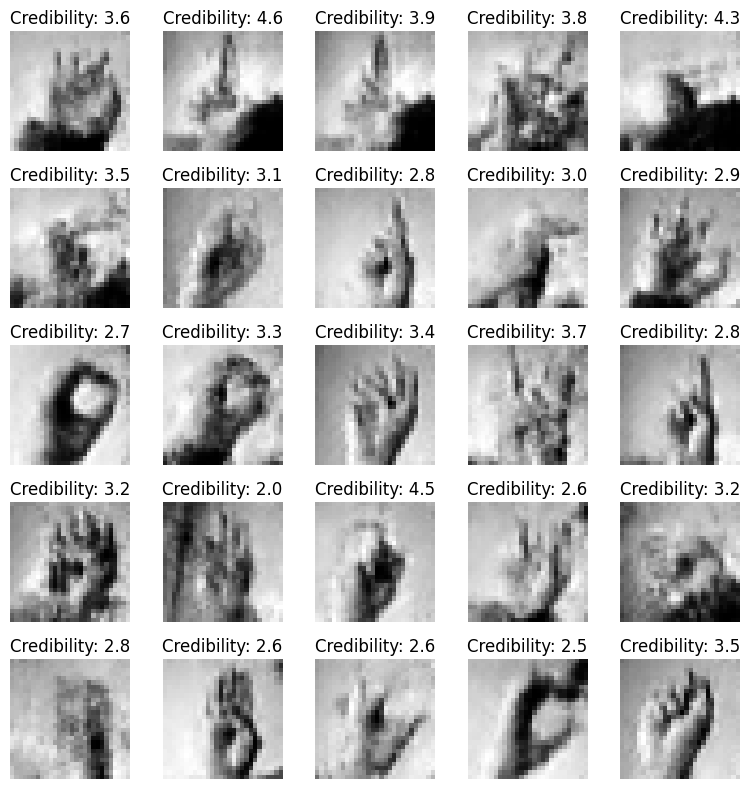

----------------------------------------------------------------------------------------------------
Epoch 17/20


100%|██████████| 217/217 [00:51<00:00,  4.17it/s]


Training Discriminator loss : -2.537426934758639 | Training Generator loss : -2.298182888231176


100%|██████████| 28/28 [00:00<00:00, 35.20it/s]


Valid Discriminator accuracy : 0.5058475136756897


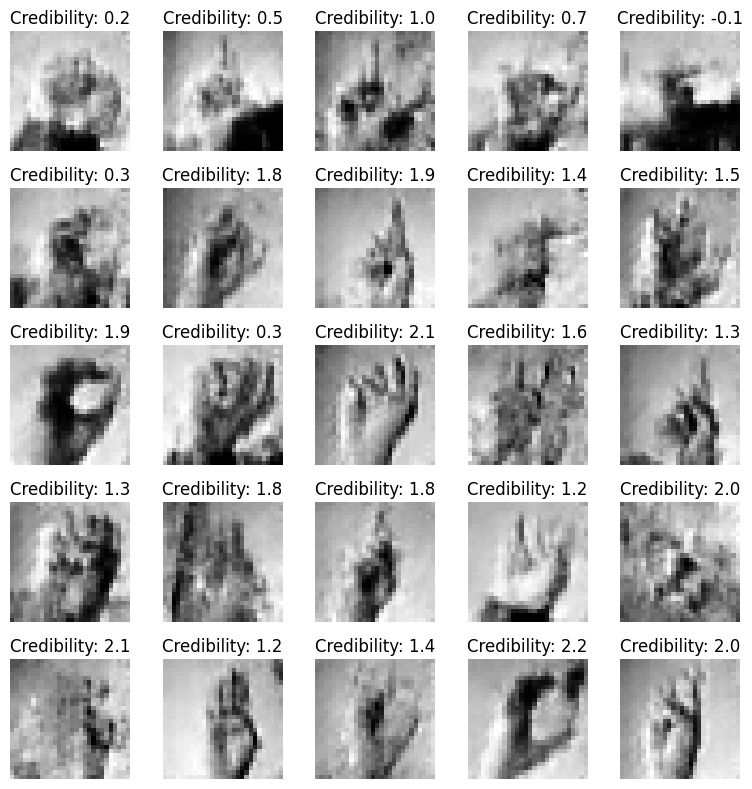

----------------------------------------------------------------------------------------------------
Epoch 18/20


100%|██████████| 217/217 [00:50<00:00,  4.32it/s]


Training Discriminator loss : -2.545442182072846 | Training Generator loss : -2.1539690978996764


100%|██████████| 28/28 [00:00<00:00, 44.16it/s]


Valid Discriminator accuracy : 0.5060641169548035


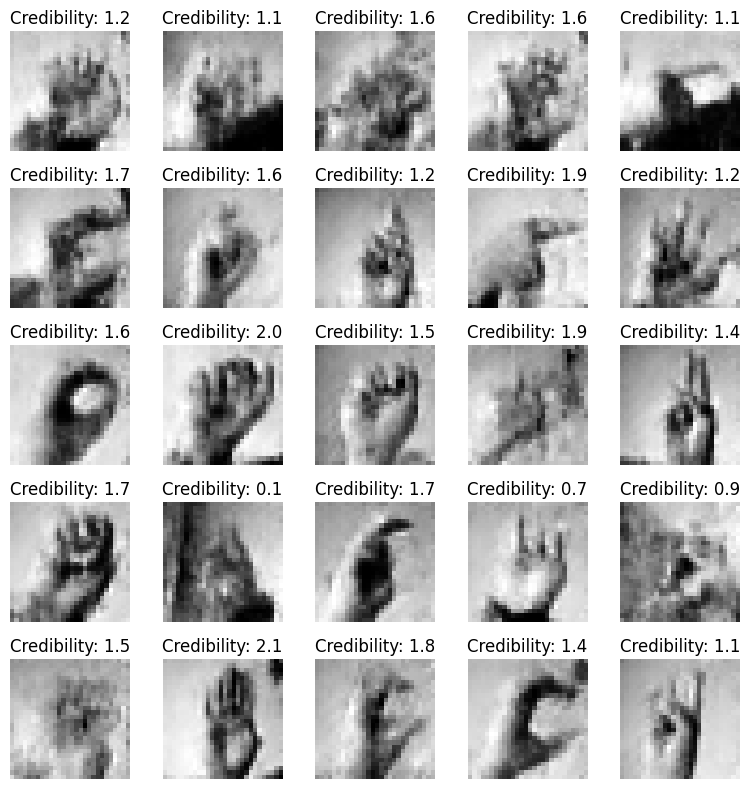

----------------------------------------------------------------------------------------------------
Epoch 19/20


100%|██████████| 217/217 [00:51<00:00,  4.20it/s]


Training Discriminator loss : -2.547466068223874 | Training Generator loss : -2.3313851388094062


100%|██████████| 28/28 [00:00<00:00, 35.25it/s]


Valid Discriminator accuracy : 0.4999999701976776


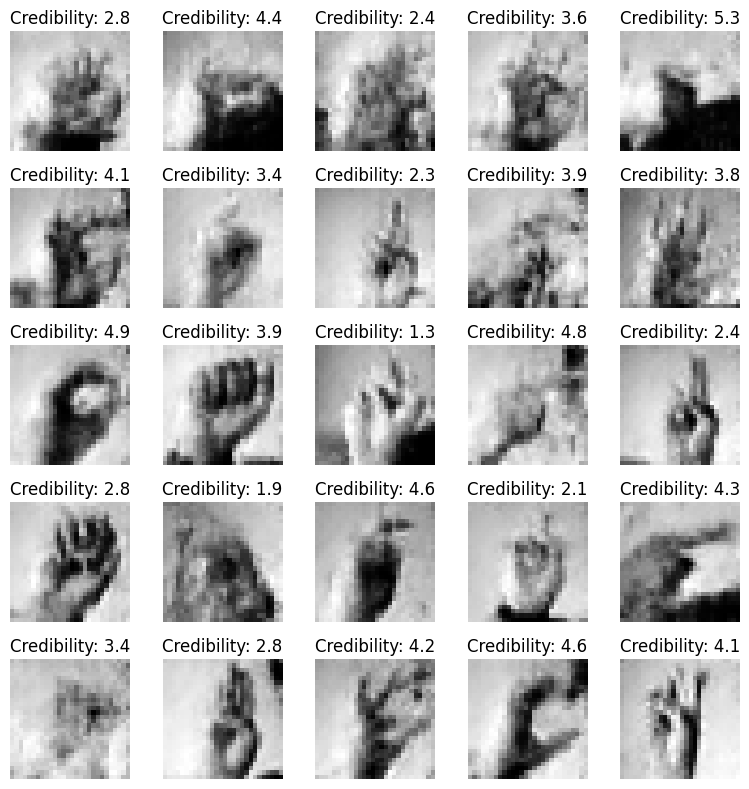

----------------------------------------------------------------------------------------------------
Epoch 20/20


100%|██████████| 217/217 [00:50<00:00,  4.32it/s]


Training Discriminator loss : -2.5542996374692786 | Training Generator loss : -2.2128375197078363


100%|██████████| 28/28 [00:00<00:00, 36.19it/s]


Valid Discriminator accuracy : 0.4999999701976776


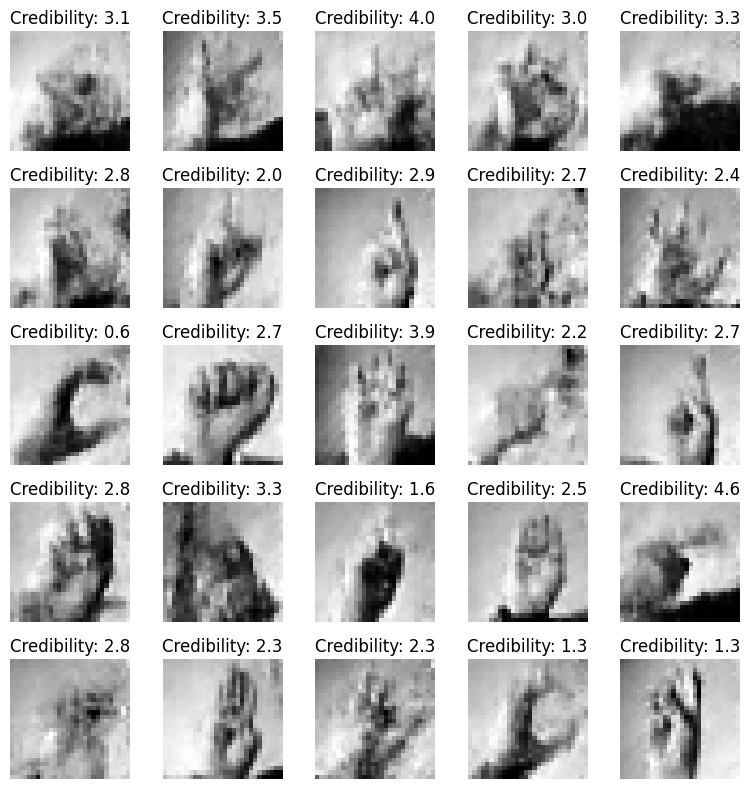

----------------------------------------------------------------------------------------------------


In [12]:
figs = []
for epoch in range(Hyperparams.num_epochs):
    print(f'Epoch {epoch +1}/{Hyperparams.num_epochs}')
    train(train_loader, generator, discriminator, device, g_optimizer, d_optimizer, distribution, epoch)
    accuracy, fig = validate(valid_loader, generator, discriminator, device, distribution, fixed_latent_vectors,epoch)
    figs.append(fig)
    print(f'-' *100)

In [14]:
#Looks like attention works against the model..

In [13]:
import imageio
import re

def create_animation(images_path):
    filenames = os.listdir(images_path)
    filenames.sort(key=lambda x: int(re.search(r"plot_epoch_(\d+).png", x).group(1)))
    
    images = [imageio.imread(os.path.join(images_path, filename)) for filename in filenames]
    imageio.mimsave('results/HANDSMNIST.gif', images, duration=10)
    return filenames


filenames = create_animation('saved_plots/HANDS_Attention-WDCGAN-GP')

/tmp/ipykernel_1573/1730228662.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(images_path, filename)) for filename in filenames]
